<a href="https://colab.research.google.com/github/raulsomazabracho/Clusterization/blob/main/Sales_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Desafío DS
Usted cuenta con una base de datos local en el archivo *tablas.db*. En esta base de datos usted tiene dos tablas, una de *Mediciones* con algunas características y la otra de *Caracteristicas* más detalladas. El objetivo de este desafio es determinar si un producto está disponible o no en el *futuro*, lo que correspone a un problema de clasificación sobre la varible **y** en la tabla de *Mediciones*.
1. **Usando SQL**, obtener el promedio para la columna **venta_unidades_dia** en  tabla *Caracteristicas*, a través de los locales, para cada **producto** y **día**.
2. **Usando SQL**, obtener la **venta_unidades_dia** del día anterior como una nueva columna en la tabla *Caracteristicas*.
3. **Usando SQL**, juntar las tablas de *Características*, con las nuevas columnas de los puntos anteriores, y *Mediciones*. ¿Cuántos elementos tiene la tabla resultante?
4. Exploración, análisis y pre-procesamiento de la data.
6. Realizar una separación de la data en entrenamiento y prueba. ¿Cómo realizará la división? ¿Qué porcentaje queda en el conjunto de prueba?
7. Entrenar un algoritmo de ML para predecir **y**. ¿Qué varibales se deberían usar como input?
8. Métricas del modelo e interpretación de los resultados. **No es necesario que el modelo tenga buenas métricas, lo que importa es el método**.

In [1]:
#Conexión a la DB
import sqlite3

#Manipulacion y visualización de data
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import plotly.express as px

#Procesamiento de la Data
from sklearn.preprocessing import MinMaxScaler

#Modelado de Machine Learning
from sklearn.ensemble import RandomForestClassifier

#Métricas del modelo de Machine Learning
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
con = sqlite3.connect('/content/drive/MyDrive/Data Science/Python/Regresiones (Supervised)/Forecasting/Clasificacion en serie de tiempo/Copia de tablas.db')

In [4]:
df = pd.read_sql_query("""SELECT * FROM Mediciones """, con)
df.head()

,fecha,local,ID,venta_clp_dia,venta_0_acum,y
0,2021-02-16,14,18,3344.0,0,1.0
1,2021-03-22,14,18,0.0,1,1.0
2,2021-04-27,14,18,0.0,3,1.0
3,2021-03-19,14,18,0.0,1,1.0
4,2021-04-24,14,18,2479.0,0,1.0


In [5]:
df = pd.read_sql_query("""
SELECT * FROM Caracteristicas

""", con)
df.head()

,fecha,local,ID,venta_unidades_dia,stock
0,2021-05-29,25,306,17.0,0.0
1,2021-04-11,25,389,3.0,7.0
2,2021-01-13,25,389,0.0,0.0
3,2021-05-08,24,174,3.0,66.0
4,2021-01-24,1,334,0.0,27.0


# 1 Promedio Ventas Diarias por Fecha-Id-Local en Caracteristicas

In [6]:
#COLUMNA_1

#Selecciono las columnas de caracteristicas tomando el promedio de ventas, luego agrupo por fecha, local e id

columna_1 = pd.read_sql_query(
""" 
    SELECT 
    A.FECHA, A.LOCAL, A.ID , avg(venta_unidades_dia) as Promedio_Ventas_Diarias
    FROM Caracteristicas as A
    group by A.FECHA, A.LOCAL, A.ID
""", con)
columna_1

,fecha,local,ID,Promedio_Ventas_Diarias
0,2021-01-01,0,10,0.0
1,2021-01-01,0,100,0.0
2,2021-01-01,0,101,0.0
3,2021-01-01,0,102,0.0
4,2021-01-01,0,103,0.0
...,...,...,...,...
1304625,2021-05-31,9,91,0.0
1304626,2021-05-31,9,92,0.0
1304627,2021-05-31,9,95,5.0
1304628,2021-05-31,9,96,0.0


#2 Ventas Diarias por Dia anterior por Fecha-Id-Local en Caracteristicas

In [7]:
# Creo una tabla igual a la de caracteristicas, pero a la nueva le sumo un dia a la fecha
# De esta manera al hacer el join con caracteristicas hace con la fecha siguiente y por eso  trae las ventas del dia anterior

columna_2 = pd.read_sql_query(
"""
SELECT 
  A.FECHA , B.FECHA , B.ventas_dia_anterior
FROM
(SELECT DISTINCT LOCAL, ID , FECHA FROM CARACTERISTICAS) A
INNER JOIN
(SELECT DISTINCT LOCAL , ID, FECHA , DATE(FECHA,'+1 days') as AUX, venta_unidades_dia as ventas_dia_anterior FROM CARACTERISTICAS) B
ON A.LOCAL = B.LOCAL AND A.ID= B.ID AND A.FECHA = B.AUX
--WHERE A.FECHA IN ( '2021-04-11' , '2021-01-13' , '2021-05-29')
--AND A.LOCAL = 25 
--AND A.ID = 389
""", con)
columna_2

,FECHA,FECHA,ventas_dia_anterior
0,2021-05-29,2021-05-28,11.0
1,2021-04-11,2021-04-10,1.0
2,2021-01-13,2021-01-12,0.0
3,2021-05-08,2021-05-07,3.0
4,2021-01-24,2021-01-23,1.0
...,...,...,...
1295652,2021-04-15,2021-04-14,0.0
1295653,2021-05-07,2021-05-06,0.0
1295654,2021-04-28,2021-04-27,0.0
1295655,2021-04-04,2021-04-03,0.0


# 3 Consolidación

In [8]:
#Dataframe a crear ----> "Total"

# Consolidamos los 2 pasos anteiores y agregamos la tabla "Mediciones" a los join

total = pd.read_sql_query (
"""
SELECT 
  A.FECHA as FECHA ,
  A.id as ID,
  A.Local as LOCAL,
  A.STOCK,
  A.venta_unidades_dia as VENTAS_UNIDADES_DIA,
  C.Promedio_Ventas_Diarias as PROMEDIO_VENTAS_DIARIA,
  B.venta_unidades_dia as VENTAS_UNIDADES_DIA_ANTERIOR,
  D.venta_clp_dia as VENTAS_CLP_DIA,
  D.venta_0_acum as VENTAS_0_ACUM,
  D.Y as Y

  
FROM
  (SELECT DISTINCT LOCAL, ID , FECHA, STOCK , venta_unidades_dia FROM CARACTERISTICAS) A
INNER JOIN
  (
  SELECT DISTINCT 
      LOCAL , ID, FECHA ,  DATE(FECHA,'+1 days') AS AUX , venta_unidades_dia 
  FROM CARACTERISTICAS
  ) B
ON A.LOCAL = B.LOCAL AND A.ID= B.ID AND A.FECHA = B.AUX
INNER JOIN
  (SELECT 
    A.FECHA, A.LOCAL, A.ID , avg(venta_unidades_dia) as Promedio_Ventas_Diarias
    FROM Caracteristicas as A
    group by A.FECHA, A.LOCAL, A.ID

  ) C
ON A.fecha = c.FECHA and a.id = c.ID and a.local = c.LOCAL
INNER JOIN MEDICIONES D
ON A.fecha = D.fecha and a.id = D.id and a.local = D.local

--WHERE A.FECHA IN (  '2021-01-13' , '2021-05-29')
--AND A.LOCAL = 25 


""",con) 
total


,FECHA,ID,LOCAL,STOCK,VENTAS_UNIDADES_DIA,PROMEDIO_VENTAS_DIARIA,VENTAS_UNIDADES_DIA_ANTERIOR,VENTAS_CLP_DIA,VENTAS_0_ACUM,Y
0,2021-01-04,265,25,4.0,3.0,3.0,1.0,9303.0,0,1.0
1,2021-01-04,352,25,0.0,0.0,0.0,0.0,0.0,2,1.0
2,2021-01-04,352,30,2.0,2.0,2.0,1.0,4387.0,0,0.0
3,2021-01-05,0,10,24.0,8.0,8.0,3.0,12706.0,0,0.0
4,2021-01-05,1,10,5.0,31.0,31.0,15.0,36208.0,0,0.0
...,...,...,...,...,...,...,...,...,...,...
22310,2021-05-31,405,30,8.0,2.0,2.0,0.0,11748.0,0,1.0
22311,2021-05-31,435,30,30.0,0.0,0.0,0.0,0.0,14,1.0
22312,2021-05-31,436,30,21.0,0.0,0.0,0.0,0.0,2,1.0
22313,2021-05-31,451,30,42.0,0.0,0.0,0.0,0.0,21,1.0


In [9]:
total.shape

(22315, 10)

El Dataset está conformado por 22315 registros y 10 atributos:

  -Las 5 originales de "Caracteristicas"

  -Las 2 agregadas con los calculos

  -Las 3 unicas de "Mediciones"

# 4 Exploración, análisis y pre-procesamiento de la data.

## Exploración Inicial

In [10]:
# Vemos Cabecera de Dataset
total.head()

,FECHA,ID,LOCAL,STOCK,VENTAS_UNIDADES_DIA,PROMEDIO_VENTAS_DIARIA,VENTAS_UNIDADES_DIA_ANTERIOR,VENTAS_CLP_DIA,VENTAS_0_ACUM,Y
0,2021-01-04,265,25,4.0,3.0,3.0,1.0,9303.0,0,1.0
1,2021-01-04,352,25,0.0,0.0,0.0,0.0,0.0,2,1.0
2,2021-01-04,352,30,2.0,2.0,2.0,1.0,4387.0,0,0.0
3,2021-01-05,0,10,24.0,8.0,8.0,3.0,12706.0,0,0.0
4,2021-01-05,1,10,5.0,31.0,31.0,15.0,36208.0,0,0.0


In [11]:
# Observamos el tipo de columnas
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22315 entries, 0 to 22314
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FECHA                         22315 non-null  object 
 1   ID                            22315 non-null  object 
 2   LOCAL                         22315 non-null  object 
 3   STOCK                         22315 non-null  object 
 4   VENTAS_UNIDADES_DIA           22315 non-null  object 
 5   PROMEDIO_VENTAS_DIARIA        22315 non-null  float64
 6   VENTAS_UNIDADES_DIA_ANTERIOR  22315 non-null  object 
 7   VENTAS_CLP_DIA                22315 non-null  object 
 8   VENTAS_0_ACUM                 22315 non-null  object 
 9   Y                             22315 non-null  object 
dtypes: float64(1), object(9)
memory usage: 1.7+ MB


 A tomar en cuenta que no se observan nulos, pero esto se puede deber al incorrecto tipo de data en cada atributo:

  -La Fecha no está en formato Fecha

  -Los siguientes atributos no están en tipo float

    -STOCK

    -VENTAS_UNIDADES_DIARIA

    -VENTAS_UNIDADES_DIA_ANTERIOR

    -VENTAS_CLP_DIA

    -VENTAS_0_ACUM
    -Y

In [12]:
#Valores destacables de features numericos
total.describe()

,PROMEDIO_VENTAS_DIARIA
count,22315.000000
mean,4.631683
std,22.475401
min,0.000000
25%,0.000000
50%,1.000000
75%,4.000000
max,1793.000000


 Poco se puede inferir ya que los atributos tienen el formato equivocado, procederemos a limpiarlos

## Pre-Procesamiento / Exploración

### Features Numericos

In [13]:
# Transformamos features restantes a numericos
lista_columnas_numericas = ["STOCK", "VENTAS_UNIDADES_DIA","VENTAS_UNIDADES_DIA_ANTERIOR","VENTAS_CLP_DIA","VENTAS_0_ACUM","Y"]
total[lista_columnas_numericas] = total[lista_columnas_numericas].apply(pd.to_numeric, errors = 'coerce')

#Comprobamos la correcta transformación
total.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22315 entries, 0 to 22314
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   FECHA                         22315 non-null  object 
 1   ID                            22315 non-null  object 
 2   LOCAL                         22315 non-null  object 
 3   STOCK                         16838 non-null  float64
 4   VENTAS_UNIDADES_DIA           22315 non-null  float64
 5   PROMEDIO_VENTAS_DIARIA        22315 non-null  float64
 6   VENTAS_UNIDADES_DIA_ANTERIOR  22231 non-null  float64
 7   VENTAS_CLP_DIA                22315 non-null  float64
 8   VENTAS_0_ACUM                 22315 non-null  int64  
 9   Y                             22315 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 1.7+ MB


Aca ya empezamos a observar data faltante en algunos atributos, luego analizaremos que hacer con esos registros

In [14]:
# Estadisticas Basicas de la Data
total.describe()

,STOCK,VENTAS_UNIDADES_DIA,PROMEDIO_VENTAS_DIARIA,VENTAS_UNIDADES_DIA_ANTERIOR,VENTAS_CLP_DIA,VENTAS_0_ACUM,Y
count,16838.000000,22315.000000,22315.000000,22231.000000,2.231500e+04,22315.000000,22315.000000
mean,72.287267,4.631683,4.631683,4.011695,9.516671e+03,29.917186,0.220255
std,206.722872,22.475401,22.475401,19.151625,3.277441e+04,135.382652,0.414428
min,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,15.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
50%,29.000000,1.000000,1.000000,1.000000,2.345000e+03,0.000000,0.000000
75%,56.000000,4.000000,4.000000,3.000000,7.696000e+03,2.000000,0.000000
max,5426.000000,1793.000000,1793.000000,1366.000000,1.511170e+06,1817.000000,1.000000


Se puede observar que las variables numericas son muy dispersas

*   STOCK: el percentil 75 es apenas 56, mientras que el maximo es 5426, es una diferencia considerables

*   VENTA_UNIDADES_DIA, PROMEDIO_VENTAS_DIARIA, VENTAS_UNIDADES_DIA_ANTERIOR: tienen comportamientos similares, compartiendo promedio y desviación estandar (casi).  Pero ocurre lo mismo que con  "Stock", se observa que los valores mas altos están muy alejados del resto





In [15]:
# Variable Target
print("% de Cada tipo de Variable Target: \n", total.Y.value_counts(normalize =True))

% de Cada tipo de Variable Target: 
 0.0    0.779745
1.0    0.220255
Name: Y, dtype: float64


### Tranformación en Time-Series

In [16]:
# Convertimos el Feature "Fecha" en formato de fecha y lo configuramos como index para nuestra serie de tiempo
total['FECHA'] = pd.to_datetime(total.FECHA, format = '%Y-%m-%d')

total.set_index('FECHA', inplace =True)
#Comprobamos correcta configuración
print(total.info())
total.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22315 entries, 2021-01-04 to 2021-05-31
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            22315 non-null  object 
 1   LOCAL                         22315 non-null  object 
 2   STOCK                         16838 non-null  float64
 3   VENTAS_UNIDADES_DIA           22315 non-null  float64
 4   PROMEDIO_VENTAS_DIARIA        22315 non-null  float64
 5   VENTAS_UNIDADES_DIA_ANTERIOR  22231 non-null  float64
 6   VENTAS_CLP_DIA                22315 non-null  float64
 7   VENTAS_0_ACUM                 22315 non-null  int64  
 8   Y                             22315 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.7+ MB
None


,ID,LOCAL,STOCK,VENTAS_UNIDADES_DIA,PROMEDIO_VENTAS_DIARIA,VENTAS_UNIDADES_DIA_ANTERIOR,VENTAS_CLP_DIA,VENTAS_0_ACUM,Y
FECHA,,,,,,,,,
2021-01-04,265,25,4.0,3.0,3.0,1.0,9303.0,0,1.0
2021-01-04,352,25,0.0,0.0,0.0,0.0,0.0,2,1.0
2021-01-04,352,30,2.0,2.0,2.0,1.0,4387.0,0,0.0
2021-01-05,0,10,24.0,8.0,8.0,3.0,12706.0,0,0.0
2021-01-05,1,10,5.0,31.0,31.0,15.0,36208.0,0,0.0


### Faltantes

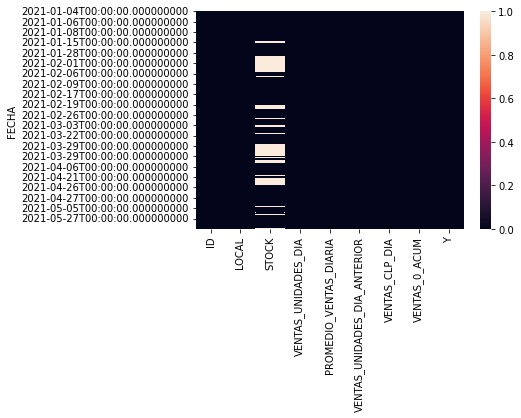

In [17]:
#Revisemos graficamente los valores faltantes cada Feature a traves de un Heatmap de Seaborn
sns.heatmap(total.isna())


In [18]:
#Observamos en forma esquematica la proporción de faltantes por cada Feature
total_null = total.isnull().sum().sort_values(ascending=False) 
porcentaje = (total.isnull().sum()/total.isnull().count()).sort_values(ascending=False)
totales_faltantes = pd.concat([total_null, porcentaje], axis=1, keys=['Total', 'Porcentaje'])
totales_faltantes

,Total,Porcentaje
STOCK,5477,0.245440
VENTAS_UNIDADES_DIA_ANTERIOR,84,0.003764
ID,0,0.000000
LOCAL,0,0.000000
VENTAS_UNIDADES_DIA,0,0.000000
PROMEDIO_VENTAS_DIARIA,0,0.000000
VENTAS_CLP_DIA,0,0.000000
VENTAS_0_ACUM,0,0.000000
Y,0,0.000000


Los valores faltantes solo se encunetran en features numericos, no en los categoricos

Asi que enfocaremos el estudio en esos especificamente

#### Stock

In [19]:
#Estudiemos un poco más el feature de "STOCK" para determinar la correcta manipulación de sus datos
no_stock_nan = total[total['STOCK'].notnull()]
stock_nan = total[total['STOCK'].isnull()]
print("% de Cada Tipo de TARGET en donde la info Stock está presente: \n", no_stock_nan.Y.value_counts(normalize =True))
print("% de Cada Tipo de TARGET en donde la info Stock --NO-- está presente: \n", stock_nan.Y.value_counts(normalize =True))
#stock_nan.head(20)

% de Cada Tipo de TARGET en donde la info Stock está presente: 
 0.0    0.810963
1.0    0.189037
Name: Y, dtype: float64
% de Cada Tipo de TARGET en donde la info Stock --NO-- está presente: 
 0.0    0.683768
1.0    0.316232
Name: Y, dtype: float64


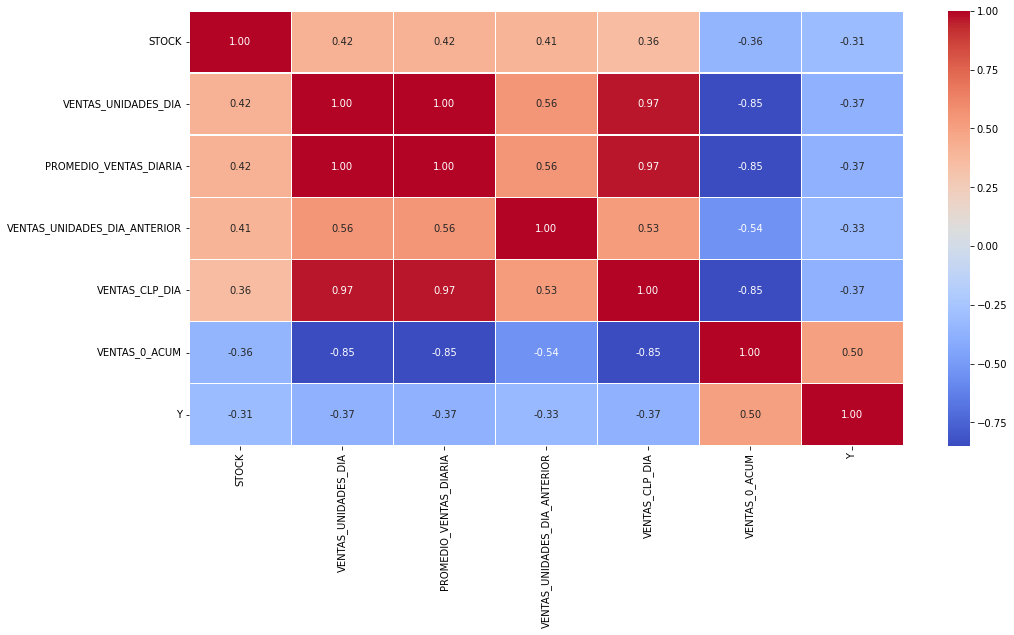

In [20]:
# Observemos la matriz de correlación entre variables (spearman) ya que las variables continuas cambian al mismo tiempo y no es monotona
corr_matrix = total.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

#### Restante de Features

In [21]:
# Imputaremos los valores faltantes con el promedio de las columnas numericas

#Primero guardamos en una lista las columnas numericas para iterar sobre ella
num_col=total._get_numeric_data().columns.tolist()

#Luego imputamos la data con el promedio de cada Feature mediante un for loop
for col in num_col:
   total[col].fillna(total[col].mean(), inplace = True)


In [22]:
total.isna().sum().sum()

0

In [23]:
# Comprobamos la correcta imputación de datos
total_null = total.isnull().sum().sort_values(ascending=False) 
porcentaje = (total_null.isnull().sum()/total.isnull().count()).sort_values(ascending=False)
totales_faltantes = pd.concat([total_null, porcentaje], axis=1, keys=['Total', 'Porcentaje'])
totales_faltantes

,Total,Porcentaje
ID,0,0.0
LOCAL,0,0.0
STOCK,0,0.0
VENTAS_UNIDADES_DIA,0,0.0
PROMEDIO_VENTAS_DIARIA,0,0.0
VENTAS_UNIDADES_DIA_ANTERIOR,0,0.0
VENTAS_CLP_DIA,0,0.0
VENTAS_0_ACUM,0,0.0
Y,0,0.0


Datos Imputados Correctamente

### EDA

#### Visualizar Serie de Tiempo

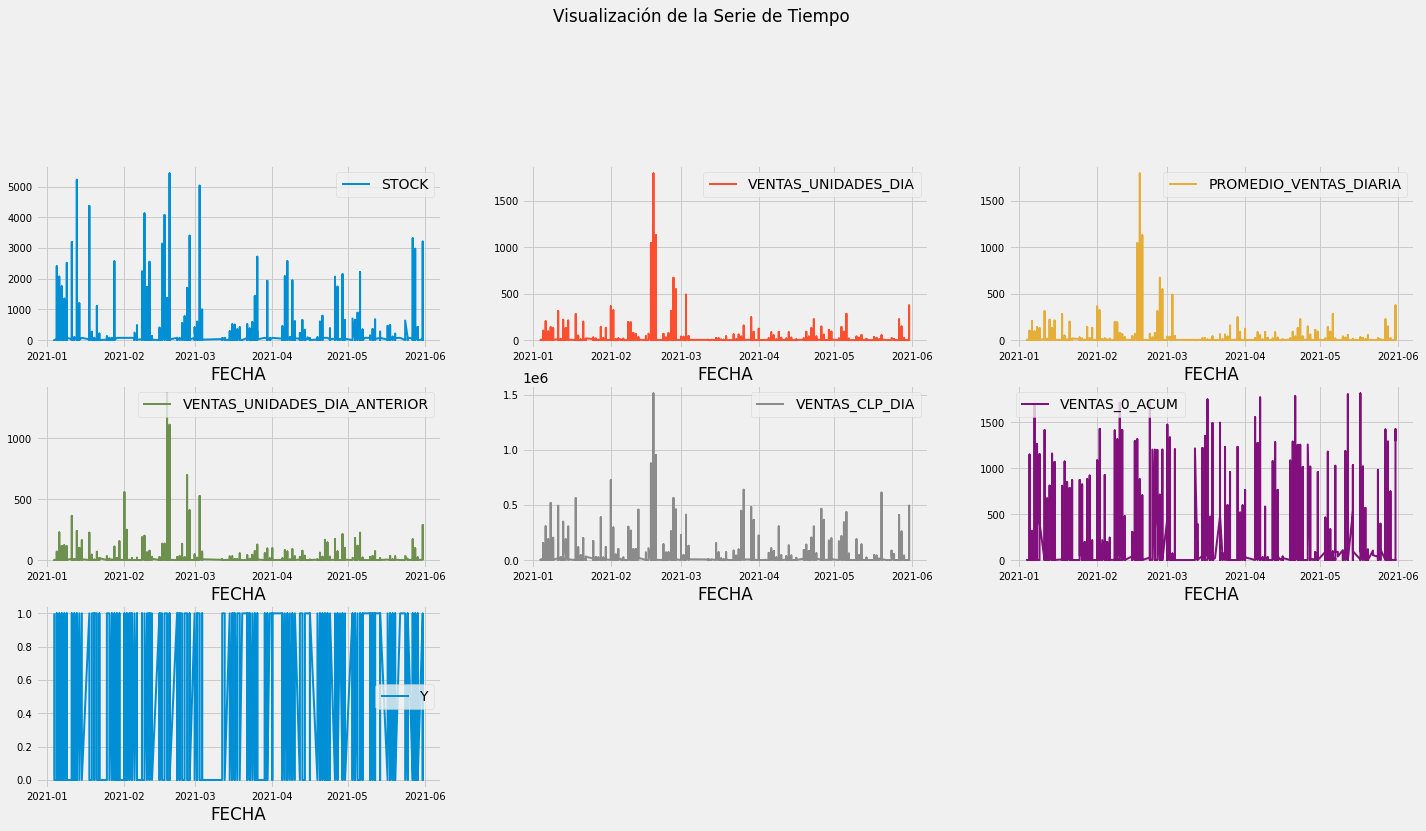

In [24]:
# Observemos nuestro Features en Cada Serie de Tiempo

plt.style.use('fivethirtyeight')
total.plot(subplots=True,
        layout=(6, 3),
        figsize=(22,22),
        fontsize=10, 
        linewidth=2,
        sharex=False,
        title='Visualización de la Serie de Tiempo')
plt.show()

Se observan comportamiento similares en las graficas de ventas, con lo cual podemos inferir que ese salto en las ventas a mediados/finales de febrero es correcto, 

Stock se vino abajo un par de semanas después de ese incremento en las ventas (lo cual hace sentido) y la variable target muestra un continuidad en la categoría "0" en el mismo periodo en el cual se cae el stock

#### Correlación entre features numéricos

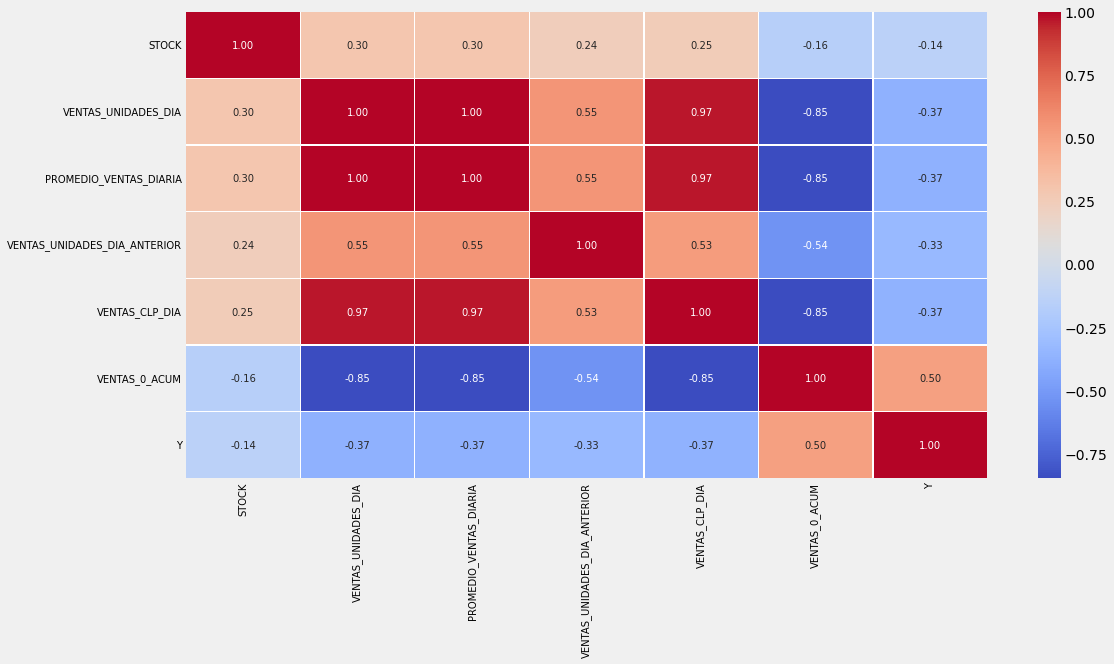

In [25]:
# Observemos la matriz de correlación entre variables (Spearman) ya uqe las variables continuas cambian al mismo tiempo
corr_matrix = total.corr(method='spearman')
f, ax = plt.subplots(figsize=(16,8))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', linewidth=0.4,
            annot_kws={"size": 10}, cmap='coolwarm', ax=ax)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

Nuestra variable target parece tener mas relación con el feature de "VENTA_0_ACUM" que con el resto de features, los cuales se encuentran en valores similares

La venta diaria y el promedio de venta diaria están perfectamente correlacionadas, no es ideal para entrenar un modelo de Machine Learning, por lo cual en pasos más adelante cambiaremos esto

#### Features Categóricos

In [26]:
#Cuantos Valores unicos tiene LOCAL
total["LOCAL"].nunique()

31

Exiten 31 locales en la DB

In [27]:
# Ver las estadisticas de ventas por "LOCAL"
locales = total.groupby("LOCAL").agg({"VENTAS_UNIDADES_DIA": ["sum", "mean", "median", "std"],'Y':'sum'})
locales

VENTAS_UNIDADES_DIA                                   Y
                      sum       mean median        std    sum
LOCAL                                                        
0                   167.0   0.795238    0.0   1.856316  113.0
1                  3616.0   3.587302    1.0  10.676163  196.0
10                 3768.0   4.733668    2.0  13.458790  102.0
11                 1155.0   1.890344    0.0  13.299307  345.0
12                 1149.0   1.534045    0.0   2.846891   20.0
13                 1341.0   2.312069    1.0   5.053516   30.0
14                  938.0   0.849638    0.0   2.101901  916.0
15                  918.0   1.832335    1.0   4.031852   72.0
16                 1288.0   1.808989    0.0   4.727456  229.0
17                 4066.0   4.922518    1.0  13.597729  146.0
18                  165.0   0.411471    0.0   1.439711  176.0
19                  566.0   1.189076    0.0   3.030714  169.0
2                  7774.0   7.868421    2.0  58.398596  216.0
20                 1318.0   2.018377    1.0   4.499110   61.0
21                 3580.0   4.138728    2.0   9.577375  120.0
22                 9744.0  11.985240    4.0  46.057790  163.0
23                 6893.0   8.215733    3.0  26.261217   51.0
24                10787.0  11.623922    4.0  35.511545   98.0
25                 5717.0   5.660396    2.0  17.970037  181.0
26                 2277.0   3.557812    1.0   8.627563   56.0
27                 4694.0   5.689697    2.0  22.618366   81.0
28                  696.0   0.807425    0.0   1.906658  377.0
29                 7523.0   9.451005    2.0  31.199280   61.0
3                  2233.0   3.118715    1.0   6.690449  157.0
30                 6716.0   7.017764    2.0  39.769192  138.0
4                  1833.0   3.261566    1.0   7.140873   32.0
5                  2580.0   3.920973    1.0   8.135262  207.0
6                  4279.0   6.512938    2.0  18.890415   77.0
7                  1003.0   2.464373    1.0   5.731521  108.0
8                  2552.0   4.225166    2.0   9.002614   60.0
9                  2020.0   3.600713    1.0  10.767391  157.0

La tienda con mayor cantidad de registros con una variable target = '1' es la 14

Mientras que la 12 y la 13 destacan por no tener mayoria de targets = '0

In [28]:
# Ver Estadistcas de la variable target por LOCAL
total["ID"].nunique()

429

Existen 429 productos existentes en la DB

In [29]:
#Ver las estadisticas del feature "ID"
id = total.groupby("ID").agg({"VENTAS_UNIDADES_DIA": ["sum", "mean", "median", "std"],'Y':'sum'})
id

VENTAS_UNIDADES_DIA                                Y
                    sum      mean median       std   sum
ID                                                      
0                 234.0  2.228571    2.0  2.602725   7.0
1                 334.0  8.146341    6.0  8.305302   8.0
10                223.0  2.207921    1.0  2.706721   8.0
100               182.0  1.784314    1.0  2.913361  17.0
101                57.0  0.826087    0.0  1.798337  13.0
..                  ...       ...    ...       ...   ...
95                185.0  2.228916    1.0  3.017531  19.0
96                  0.0  0.000000    0.0  0.000000   5.0
97                  0.0  0.000000    0.0  0.000000  12.0
98                  2.0  0.166667    0.0  0.389249   6.0
99                106.0  1.376623    1.0  1.878122   5.0

[429 rows x 5 columns]

#### Variable Target

In [30]:
#Separamos cuando el target del resto de variables
print("Proporción de la variable Target en Dataset \n", total.Y.value_counts(normalize = True))
y = total.loc[:,'Y']
y.head()

#Vemos como varia en el tiempo la variable a través de Plotly
px.line(y, x = y.index, y = y)

Proporción de la variable Target en Dataset 
 0.0    0.779745
1.0    0.220255
Name: Y, dtype: float64


Lo primero a observar es que el Target es una variable altamente desbalanceada, casi 80% de los datos se encuentran en la categoria "0", importante este dato ya que el modelo de ML no tendrá muchos datos para aprender a predecir la categoría "1" y puede tender a catalogar más de los reales como "0"

En la evolución en el tiempo no se observa un patrón definido, dificil sacar alguna conclusión a partir de esto

### Pre-Procesamiento:

In [31]:
total.head()

,ID,LOCAL,STOCK,VENTAS_UNIDADES_DIA,PROMEDIO_VENTAS_DIARIA,VENTAS_UNIDADES_DIA_ANTERIOR,VENTAS_CLP_DIA,VENTAS_0_ACUM,Y
FECHA,,,,,,,,,
2021-01-04,265,25,4.0,3.0,3.0,1.0,9303.0,0,1.0
2021-01-04,352,25,0.0,0.0,0.0,0.0,0.0,2,1.0
2021-01-04,352,30,2.0,2.0,2.0,1.0,4387.0,0,0.0
2021-01-05,0,10,24.0,8.0,8.0,3.0,12706.0,0,0.0
2021-01-05,1,10,5.0,31.0,31.0,15.0,36208.0,0,0.0


In [32]:
total.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 22315 entries, 2021-01-04 to 2021-05-31
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            22315 non-null  object 
 1   LOCAL                         22315 non-null  object 
 2   STOCK                         22315 non-null  float64
 3   VENTAS_UNIDADES_DIA           22315 non-null  float64
 4   PROMEDIO_VENTAS_DIARIA        22315 non-null  float64
 5   VENTAS_UNIDADES_DIA_ANTERIOR  22315 non-null  float64
 6   VENTAS_CLP_DIA                22315 non-null  float64
 7   VENTAS_0_ACUM                 22315 non-null  int64  
 8   Y                             22315 non-null  float64
dtypes: float64(6), int64(1), object(2)
memory usage: 1.7+ MB


Para Nuestro analisis, como bien observamos en la exploración de la data tenemos 2 varibales totalmente correlaciones como lo son:


*  "VENTA_UNIDADES_DIA"
 -
*  "PROMEDIO_VENTAS_DIARIA"

Así que para simplificar el modelo y que aprenda de mejor manera eliminaremos el promedio, esa info será aportada directamente con el valor de la venta diaria

In [33]:
#Primero Sacamos el promedio de venta diario
total.drop('PROMEDIO_VENTAS_DIARIA',axis =1, inplace = True)
total.head(-5)

,ID,LOCAL,STOCK,VENTAS_UNIDADES_DIA,VENTAS_UNIDADES_DIA_ANTERIOR,VENTAS_CLP_DIA,VENTAS_0_ACUM,Y
FECHA,,,,,,,,
2021-01-04,265,25,4.000000,3.0,1.0,9303.0,0,1.0
2021-01-04,352,25,0.000000,0.0,0.0,0.0,2,1.0
2021-01-04,352,30,2.000000,2.0,1.0,4387.0,0,0.0
2021-01-05,0,10,24.000000,8.0,3.0,12706.0,0,0.0
2021-01-05,1,10,5.000000,31.0,15.0,36208.0,0,0.0
...,...,...,...,...,...,...,...,...
2021-05-31,268,30,20.000000,0.0,0.0,0.0,6,1.0
2021-05-31,269,30,18.000000,0.0,0.0,0.0,21,1.0
2021-05-31,30,30,101.000000,9.0,7.0,19029.0,0,1.0


Insertaremos el dia del mes como variable directamente al modelo

No tomamremos el mes porqué en el Train_Test_Split separaremos el dataset por fecha y no podremos replicar en el entrenamiento el mes ya que tendrán valores distintos

In [34]:
# Agregamos columna de Mes y Dia
total['FECHA'] = total.index
total['DIA'] =total.FECHA.dt.day
total.head()

,ID,LOCAL,STOCK,VENTAS_UNIDADES_DIA,VENTAS_UNIDADES_DIA_ANTERIOR,VENTAS_CLP_DIA,VENTAS_0_ACUM,Y,FECHA,DIA
FECHA,,,,,,,,,,
2021-01-04,265,25,4.0,3.0,1.0,9303.0,0,1.0,2021-01-04,4
2021-01-04,352,25,0.0,0.0,0.0,0.0,2,1.0,2021-01-04,4
2021-01-04,352,30,2.0,2.0,1.0,4387.0,0,0.0,2021-01-04,4
2021-01-05,0,10,24.0,8.0,3.0,12706.0,0,0.0,2021-01-05,5
2021-01-05,1,10,5.0,31.0,15.0,36208.0,0,0.0,2021-01-05,5


#### Variables Numéricas

Normalizaremos las variables numericas a través de "MinMaxScaler" para que nos queden de manera acotaday ayude al modelo que utilizaremos a clasificar correctamente cada input

In [35]:
#Sacamos nuestra variable target
target = total[['Y']]

#Definimos el Normalizador
scaler = MinMaxScaler()  

#Seleccionamos las variables numericas
features_categoricos = total.loc[:,['DIA','LOCAL','ID']] #Categoricas
features_numericos = total.loc[:,['VENTAS_UNIDADES_DIA','VENTAS_UNIDADES_DIA_ANTERIOR','VENTAS_CLP_DIA','VENTAS_0_ACUM']] #numericas

# Normalizamos los valores con MinMaxScaler
features_numericos_normalizados= pd.DataFrame(scaler.fit_transform(features_numericos.values),index=features_numericos.index,columns=features_numericos.columns)

#Los Adjuntamos al Dataset
total_normalizado = pd.concat([features_categoricos ,features_numericos_normalizados],axis =1)

total_normalizado.head()

,DIA,LOCAL,ID,VENTAS_UNIDADES_DIA,VENTAS_UNIDADES_DIA_ANTERIOR,VENTAS_CLP_DIA,VENTAS_0_ACUM
FECHA,,,,,,,
2021-01-04,4,25,265,0.001673,0.000732,0.006156,0.000000
2021-01-04,4,25,352,0.000000,0.000000,0.000000,0.001101
2021-01-04,4,30,352,0.001115,0.000732,0.002903,0.000000
2021-01-05,5,10,0,0.004462,0.002196,0.008408,0.000000
2021-01-05,5,10,1,0.017289,0.010981,0.023960,0.000000


#### Variables Categoricas

Las variables categoricas deben ser manejada como valores binarios de cada categoría, si no se trabajan así el modelo puede llegar a pensar que es una variable continua y el aprendizaje será incorrecto

In [36]:
total_normalizado_dummies= pd.get_dummies(total_normalizado, columns=['DIA','LOCAL','ID'])
total_normalizado_dummies.head(10)

,VENTAS_UNIDADES_DIA,VENTAS_UNIDADES_DIA_ANTERIOR,VENTAS_CLP_DIA,VENTAS_0_ACUM,DIA_1,DIA_2,DIA_3,DIA_4,DIA_5,DIA_6,DIA_7,DIA_8,DIA_9,DIA_10,DIA_11,DIA_12,DIA_13,DIA_14,DIA_15,DIA_16,DIA_17,DIA_18,DIA_19,DIA_20,DIA_21,DIA_22,DIA_23,DIA_24,DIA_25,DIA_26,DIA_27,DIA_28,DIA_29,DIA_30,DIA_31,LOCAL_0,LOCAL_1,LOCAL_10,LOCAL_11,LOCAL_12,...,ID_61,ID_62,ID_63,ID_64,ID_65,ID_66,ID_67,ID_68,ID_69,ID_7,ID_70,ID_71,ID_74,ID_75,ID_76,ID_77,ID_78,ID_79,ID_8,ID_80,ID_81,ID_82,ID_83,ID_84,ID_85,ID_86,ID_87,ID_88,ID_89,ID_9,ID_90,ID_91,ID_92,ID_93,ID_94,ID_95,ID_96,ID_97,ID_98,ID_99
FECHA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.001673,0.000732,0.006156,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-04,0.000000,0.000000,0.000000,0.001101,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-04,0.001115,0.000732,0.002903,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-05,0.004462,0.002196,0.008408,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-05,0.017289,0.010981,0.023960,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-05,0.002231,0.004392,0.004204,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-05,0.000558,0.000732,0.002663,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-05,0.000558,0.000732,0.001885,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-05,0.000000,0.000732,0.000000,0.000550,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#5 Train_test_split

Dividiremos la data desde del primer dia disponible hasta el 30 de Abril, para que la data esté dividida en 80% y 20%

Considero que es una muestra representativa de los datos que estamos evaluando


In [37]:
# Seleccionamos las fechas para Train y para Test
train_features = total_normalizado_dummies.loc['2021-01-04':'2021-04-30'] #Fecha
train_target = target.loc['2021-01-04':'2021-04-30']  #Fecha

test_features = total_normalizado_dummies.loc['2021-05-01':'2021-05-31'] #Fecha
test_target = target.loc['2021-05-01':'2021-05-31'] #Fecha

#Separamos Variables Dependiente de las varibales Independientes del trainset
X_train = train_features
Y_train = train_target
print("Tamaño Feature Train : ", X_train.shape)
print("Tamaño Target Train: ", Y_train.shape)

#Separamos Variables Dependiente de las varibales Independientes del testset
X_test = test_features
Y_test = test_target
print("Tamaño Feature Test: ", X_test .shape)
print("Tamaño Target  Test: ", Y_test.shape)

X_train.head()

Tamaño Feature Train :  (19890, 495)
Tamaño Target Train:  (19890, 1)
Tamaño Feature Test:  (2425, 495)
Tamaño Target  Test:  (2425, 1)


,VENTAS_UNIDADES_DIA,VENTAS_UNIDADES_DIA_ANTERIOR,VENTAS_CLP_DIA,VENTAS_0_ACUM,DIA_1,DIA_2,DIA_3,DIA_4,DIA_5,DIA_6,DIA_7,DIA_8,DIA_9,DIA_10,DIA_11,DIA_12,DIA_13,DIA_14,DIA_15,DIA_16,DIA_17,DIA_18,DIA_19,DIA_20,DIA_21,DIA_22,DIA_23,DIA_24,DIA_25,DIA_26,DIA_27,DIA_28,DIA_29,DIA_30,DIA_31,LOCAL_0,LOCAL_1,LOCAL_10,LOCAL_11,LOCAL_12,...,ID_61,ID_62,ID_63,ID_64,ID_65,ID_66,ID_67,ID_68,ID_69,ID_7,ID_70,ID_71,ID_74,ID_75,ID_76,ID_77,ID_78,ID_79,ID_8,ID_80,ID_81,ID_82,ID_83,ID_84,ID_85,ID_86,ID_87,ID_88,ID_89,ID_9,ID_90,ID_91,ID_92,ID_93,ID_94,ID_95,ID_96,ID_97,ID_98,ID_99
FECHA,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-01-04,0.001673,0.000732,0.006156,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-04,0.000000,0.000000,0.000000,0.001101,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-04,0.001115,0.000732,0.002903,0.000000,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-05,0.004462,0.002196,0.008408,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2021-01-05,0.017289,0.010981,0.023960,0.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#6 Deployment del Modelo de Machine Learning

Ya insertamos la variable de fecha al modelo para su correcto deployment, ya que la data viene en forma de "Time-Series" , esta puede traer información importante y es clave no omitirla al momento de desplegar el modelo

Trataremos este modelo como un modelo de agrupación supervisada, existen muchos modelos que se pueden implementar:
 

*   Logistic Regression 
*   Desition Tree
*    XGboost


Para este proyecto utilizaremos un "Random Forest" ajustado con hiperparametros, es un modelo robusto en clasificaciones de esta indole, se sacrifica recursos por mejor segmentación

## Entrenamiento del modelo seleccionado

In [41]:
#Importamos el modelo
#from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators = 40, criterion = 'gini', random_state = 45)
rf.fit(X_train,Y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().



RandomForestClassifier(n_estimators=40, random_state=45)

## Resultados del modelo seleccionado

### Matriz de Confusión

In [45]:
##Importamos libererias
from sklearn import metrics
from sklearn.metrics import confusion_matrix

#Vemos la matriz de confusión
Y_predic= rf.predict(X_test)
pd.DataFrame(confusion_matrix(Y_test,Y_predic), columns = ['Predicho 0', 'Predicho 1'], index = ['Verdaderamente 0', 'verdaderamente 1'])

,Predicho 0,Predicho 1
Verdaderamente 0,1680,52
verdaderamente 1,253,440


-La clase 0 obtuvo valores fenomenales

-La clase 1 presenta unos resultados que pueden ser mejorados

Como habiamos intuido al algoritmo le costó más acertar el grupo que se encontraba con menor numero de registros en la data desbalanceada

### AUC/ ROC

In [46]:
#AUC
from sklearn.metrics import roc_auc_score

auc_roc = metrics.roc_auc_score(Y_predic,Y_test)
print(auc_roc)

0.8817121539037429


In [47]:
from sklearn.metrics import roc_curve, auc
false_positive_rate, true_positive_rate, thresholds = roc_curve(Y_test, Y_predic)
roc_auc = auc(false_positive_rate, true_positive_rate)
roc_auc

0.8024487701162066

Text(0.5, 0, 'False Positive Rate')

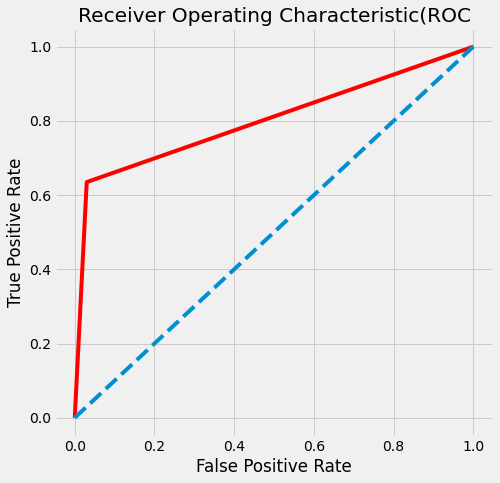

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize =(7,7))
plt.title("Receiver Operating Characteristic(ROC")
plt.plot(false_positive_rate,true_positive_rate, color='red',label = 'AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1],linestyle='--')
plt.axis('tight')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

En la primera aproximación a los reaultados del modelo obtenidos, observamos unos buenos valores de auc_roc = 86%

Ahora bien, cuando estudiamos la data al comienzo del ejercicio observamos que el target estaba desbalanceado, asi que solo quedarnos con esta metrica sería errado de nuestra parte


### PRC

In [49]:
#importamos las librerias
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [50]:
#sacamos las metricas
lr_precision, lr_recall, _ = precision_recall_curve(Y_test, Y_predic)
lr_f1, lr_auc = f1_score(Y_test, Y_predic), auc(lr_recall, lr_precision)
# sumamos los scores e imprimimos
print('Random Forest: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))

Random Forest: f1=0.743 auc=0.817


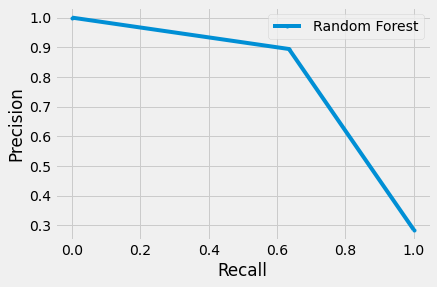

In [51]:
# graficamos el prc
plt.plot(lr_recall, lr_precision, marker='.', label='Random Forest')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

El F1_score que es buena metrica para analizar ambas clases, obtuvo un valor de 0.71
Aca se observa de mejor manera que los resultados no son optimo al momento de predecir la clase  minoritaria en el Dataset



### Feature Importance

In [56]:
#Observamos cual es el feature que mas pesa en la toma de desiciones
feature_scores = pd.Series(rf.feature_importances_, index=train_features.columns).sort_values(ascending=False)
feature_scores_df = feature_scores.to_frame()
feature_scores_df.head(10)

,0
VENTAS_0_ACUM,0.199698
VENTAS_UNIDADES_DIA,0.074601
LOCAL_14,0.067033
VENTAS_CLP_DIA,0.061671
VENTAS_UNIDADES_DIA_ANTERIOR,0.057328
DIA_22,0.021539
DIA_2,0.010060
LOCAL_28,0.009629
LOCAL_11,0.008284
LOCAL_16,0.007810


Mediante estos valores observaos lo importante que es para el modelo el feature "VENTAS_0_ACUM"

De fetures Categoricos el LOCAL_14 es muy importante a la hora de segmentar, lo cual guarda sentido con el  EDA que hicimos en pasos anteriores



Para Predecir nuevo valores el usuario deberá colocar al comienzo del PIPELINE:


*   ID
*   LOCAL
*   DIA DEL MES
*   VENTAS_0-CUM
*   VENTAS_UNIDADES_DIA
*   VENTAS_UNIDADES_DIA_ANTERIOR
*   STOCK

# Next Steps

Para mejora continua del proyecto se puede tratar con otra alternativas de Machine Learningmás complejas, como:


**Forecast:**

Al tratarse de una serie de tiempo se podria aproximar el modelo como un problema de forecast.

Modelos como ARIMA y SARIMAX pueden servir pero como no es una data muy grande y el costo de procesamiento no es tan importante es preferible utilizar una Red Neuronal, las cuales son más robustas a la hora de clasificaciones en series de tiempo

**RRN/LST:**
Para  futuros proyectos con mayor recursos y disponibilidad de tiempo, recomiendo analizar todo a través de:
Red Neuronales del tipo "Long short-term memory (LSTM)"

Este tipo de Red Neuronal se acopla bien a la clasificación de atributos en una serie de tiempo, estas series se basan mucho en tendencias, dependencias en el tiempo y patrones, y es allí donde saca ventaja sobre otros tipos de Redes Neuronales